In [573]:
#importing necessary packages
import pandas as pd
import numpy as np
import requests
import os
import glob
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
%matplotlib inline

### Gathering Data

#### Gevin Data

In [4]:
# read tee geiven csv file as df using pandas
archive_df = pd.read_csv('twitter-archive-enhanced.csv')


#### Downloading files from internet

In [33]:
# downloading and save tweet image predictions data programmatically uing requests
file_url ='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

respons = requests.get(file_url)          # get the respons object 
file_name = file_url.split('/')[-1]       # extract the file name from file_url string
if not os.path.isfile(file_name) :        # to avoid file overwriting
    with open(file_name ,'wb') as file:  # open the file & write on it 
        file.write(respons.content) 
        
# read the file as df using pandas
image_predictions_df = pd.read_csv('image-predictions.tsv',sep='\t')

#### API

In [39]:
# create an API object to gather Twitter data.
api_key = '********************'
api_key_secret = '********************'
access_token = '********************'
access_token_secret = '********************'

auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)

In [80]:
# Try to extract information from one tweet to ensure that the api project created correctly
tweet_try = api.get_status(archive_df.tweet_id[1111],tweet_mode='extended')
tweet_content = tweet_try._json
print(tweet_content)

{'created_at': 'Fri May 20 02:18:32 +0000 2016', 'id': 733482008106668032, 'id_str': '733482008106668032', 'full_text': '"Ello this is dog how may I assist" ...10/10 https://t.co/jeAENpjH7L', 'truncated': False, 'display_text_range': [0, 44], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 733481999936032768, 'id_str': '733481999936032768', 'indices': [45, 68], 'media_url': 'http://pbs.twimg.com/media/Ci3Z_idUkAA8RUh.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Ci3Z_idUkAA8RUh.jpg', 'url': 'https://t.co/jeAENpjH7L', 'display_url': 'pic.twitter.com/jeAENpjH7L', 'expanded_url': 'https://twitter.com/dog_rates/status/733482008106668032/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 768, 'h': 1024, 'resize': 'fit'}, 'small': {'w': 510, 'h': 680, 'resize': 'fit'}, 'medium': {'w': 768, 'h': 1024, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 733481999936032768, 'id_str':

In [58]:
#check the keys in the test tweet
tweet_content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [65]:
# Try to extract information from the test tweet
tweet_try.id,tweet_try.retweet_count, tweet_try.favorite_count

(733482008106668032, 912, 3031)

In [71]:
#create list with tweets id from the archive_df
id_list=[]
for tweet in archive_df.tweet_id:
    id_list.append(tweet)
id_list    

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [90]:
#write the content of tweets into .json file (line foe each tweet)
errors=[]                                          #this list to catch the tweets that don't write correctly
if not os.path.isfile('tweet_json.txt') :          # to avoid file overwriting       
    with open('tweet_json.txt','w',encoding = 'UTF-8') as file:      # create the file and write on it
        for tweet_id in id_list:
            try:
                status = api.get_status(tweet_id, tweet_mode='extended',wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
                json.dump(status._json,file)                   # write tweet content to the file
                file.write('\n')                               # create new line
            except Exception as e:
                print("There is an Error on tweet id {}".format(tweet_id) + ";" + str(e))   # notify with errors
                errors.append(tweet_id)                                         # add the tweet id to the errors list

There is an Error on tweet id 888202515573088257;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 873697596434513921;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 872668790621863937;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 872261713294495745;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 869988702071779329;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 866816280283807744;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 861769973181624320;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 856602993587888130;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error on tweet id 851953902622658560;[{'code': 144, 'message': 'No status found with that ID.'}]
There is an Error o

Rate limit reached. Sleeping for: 364


In [123]:
# read the teaxt file line by line to create df
tweet_list=[]
with open('tweet_json.txt') as file:
    for line in file:
        tweet=json.loads(line)
        tweet_list.append({'tweet_id':tweet['id'],
                         'retweet_count':tweet['retweet_count'],
                         'favorite_count':tweet['favorite_count']})
        

In [125]:
# convert the tweet_list into dF
api_df=pd.DataFrame(tweet_list,columns=['tweet_id','retweet_count','favorite_count'])

In [127]:
#save api_df into csv file
api_df.to_csv('tweet_api.csv')

### Assessing Data

#### Visual assessment

In [153]:
# view archive_df 
archive_df.head(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [151]:
# view image_predictions_df
image_predictions_df.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1323,756651752796094464,https://pbs.twimg.com/media/CoAqwPTW8AAiJlz.jpg,1,Pembroke,0.294808,True,kelpie,0.282301,True,Cardigan,0.112601,True
138,668537837512433665,https://pbs.twimg.com/media/CUcfnWlWsAAzlwE.jpg,1,Lakeland_terrier,0.372988,True,toy_poodle,0.250445,True,Chihuahua,0.189737,True
1164,735256018284875776,https://pbs.twimg.com/media/CjQnclkVEAA4pnK.jpg,1,Staffordshire_bullterrier,0.523191,True,French_bulldog,0.351104,True,doormat,0.028075,False
236,670428280563085312,https://pbs.twimg.com/media/CU3W9ELWEAEdUA0.jpg,1,chow,0.335269,True,golden_retriever,0.305850,True,Tibetan_mastiff,0.063325,True
1513,786595970293370880,https://pbs.twimg.com/media/CuqM0fVWAAAboKR.jpg,1,Pembroke,0.709512,True,Cardigan,0.287178,True,chow,0.000570,True
1531,789599242079838210,https://pbs.twimg.com/media/CvU4UZpXgAE1pAV.jpg,2,Chesapeake_Bay_retriever,0.878822,True,beagle,0.018570,True,Labrador_retriever,0.017499,True
95,667550904950915073,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,1,web_site,0.999335,False,vizsla,0.000081,True,collie,0.000069,True
1528,789137962068021249,https://pbs.twimg.com/media/CvOUw8vWYAAzJDq.jpg,2,Chihuahua,0.746135,True,Pekinese,0.070383,True,Pembroke,0.049237,True
795,690938899477221376,https://pbs.twimg.com/media/CZa1QnSWEAAEOVr.jpg,1,geyser,0.370318,False,seashore,0.274888,False,beacon,0.046397,False
1688,815390420867969024,https://pbs.twimg.com/media/C1DZQiTXgAUqgRI.jpg,1,restaurant,0.279846,False,toyshop,0.091429,False,paper_towel,0.046147,False


In [152]:
# view api_df
api_df.tail(15)

,tweet_id,retweet_count,favorite_count
2316,666094000022159362,66,153
2317,666082916733198337,41,100
2318,666073100786774016,141,284
2319,666071193221509120,52,133
2320,666063827256086533,190,438
2321,666058600524156928,51,102
2322,666057090499244032,119,262
2323,666055525042405380,214,402
2324,666051853826850816,751,1096
2325,666050758794694657,51,119


#### programmatic assessment

In [134]:
# Overview
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [139]:
# check if there is duplicate tweets
archive_df.tweet_id.nunique()

2356

In [150]:
# check if there is some dogs with no name 
archive_df.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
           ... 
Pupcasso      1
Rooney        1
Willem        1
Horace        1
Banjo         1
Name: name, Length: 957, dtype: int64

In [155]:
#check if there is some dogs with unreasonable name
archive_df[archive_df.name.apply(len) <=2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


In [156]:
# discover the doggo floofer pupper puppo columns
print(archive_df.doggo.value_counts())
print(archive_df.floofer.value_counts())
print(archive_df.pupper.value_counts())
print(archive_df.puppo.value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [168]:
# find retweets
archive_df[archive_df.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [169]:
# find replys
archive_df[archive_df.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [174]:
archive_df.rating_numerator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [ ]:
archive_df.rating_denominator.describe()

In [136]:
# Overview
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [158]:
# view statistics
api_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2618.426855,7380.339768
std,6.823170e+16,4430.616411,11462.550003
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,530.500000,1282.500000
50%,7.182469e+17,1222.000000,3201.000000
75%,7.986692e+17,3041.000000,9032.500000
max,8.924206e+17,75240.000000,152178.000000


In [159]:
# Overview
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Tidiness issues
- all dataframes are for the same observation unit so the should be in the same table
- doggo, floofer, pupper, & puppo columns in `archive_df` table are for the same variable (and there are values not  variables)
- there are three units of observation in `image_predictions_df`

#### Quality issues
- some tweets are retweets and replies 
- since retweets and replies will be removed these columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,	retweeted_status_user_id, retweeted_status_timestamp ) will be meaningless
- unnecessary columns ( source in `archive_df `),(img_num in `image_predictions_df`)
- timestamp column in `archive_df` string not datetime
- doge stage(doggo, floofer, pupper, & puppo) is string not categorical
- p1 in `image_predictions_df` is string not categorical 
- p1_dog in `image_predictions_df` is string not boolen 
- some retweet have p1_dog value = 'False' thats mean this is not a dog
- undescriptive columns names
- abnormal rating values in both rating_numerator & rating_denominator columns in `archive_df`
- unological dog names

### Data Cleaning
#### clean tidiness issues

#### Define
**1- merge the four columns (doggo, floofer, pupper, & puppo) into one column**

#### Code

In [254]:
# copy archive_df
archive_clean=archive_df.copy()

In [256]:
archive_clean['stage']= "not specified"

In [258]:
archive_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,not specified
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,not specified
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,not specified
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,not specified
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,not specified
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,not specified
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,not specified
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,not specified
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None,not specified
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,not specified


In [262]:
for x in range(0,len(archive_clean.index)) :
    if archive_clean.loc[x,'doggo'] == 'doggo':
        archive_clean.loc[x,'stage'] = 'doggo'
    elif archive_clean.loc[x,'floofer'] == 'floofer':
        archive_clean.loc[x,'stage'] = 'floofer'
    elif archive_clean.loc[x,'pupper'] == 'pupper':
        archive_clean.loc[x,'stage'] = 'pupper'
    elif archive_clean.loc[x,'puppo'] == 'puppo':
        archive_clean.loc[x,'stage'] = 'puppo'
    else :
        archive_clean.loc[x,'stage'] = 'not specified'


In [271]:
# drop doggo, floofer, pupper, and puppo columns
archive_clean=archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'],axis=1)


#### test

In [269]:
#check values of stage column
archive_clean.stage.value_counts()

not specified    1976
pupper            245
doggo              97
puppo              29
floofer             9
Name: stage, dtype: int64

<font color='green'> note that we find the sum of dogs stage after cleaning is less than before cleaning with 14 value and that's because of that some dogs have more than one stage value before cleaning, and it's ok <font>

#### Define
**2- merge archve_clean and api_df into one dataframe**
( later we will merge the image_predictions_df but after cleaning quality issues)

#### Code

In [284]:
# use merge method to merge the two tables
archive_clean=pd.merge(archive_clean,api_df ,on='tweet_id',how='left')

#### test

In [285]:
archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not specified,7454.0,35309.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified,5535.0,30560.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified,3661.0,23002.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified,7628.0,38602.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified,8224.0,36891.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,not specified,39.0,95.0
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,not specified,124.0,263.0
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,not specified,39.0,108.0
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,not specified,41.0,118.0


#### Define
**3- exract only one algorithm prediction (the most confidence one)**

### code

In [289]:
# first check for the most confidence algorithm prediction 
image_predictions_df.mean()

tweet_id    7.384514e+17
img_num     1.203855e+00
p1_conf     5.945483e-01
p1_dog      7.383133e-01
p2_conf     1.345886e-01
p2_dog      7.484337e-01
p3_conf     6.032417e-02
p3_dog      7.224096e-01
dtype: float64

In [299]:
# extract only the first algorithm prediction 
clean_image_predictions=image_predictions_df.drop(['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1)


In [301]:
#merge the newly generated dataframe with archive_clean
tweet_df=pd.merge(archive_clean,clean_image_predictions,on='tweet_id',how='left')

#### test

In [308]:
tweet_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,not specified,7454.0,35309.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,not specified,5535.0,30560.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,not specified,3661.0,23002.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,not specified,7628.0,38602.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,not specified,8224.0,36891.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,...,10,None,not specified,39.0,95.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,...,10,a,not specified,124.0,263.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,...,10,a,not specified,39.0,108.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,...,10,a,not specified,41.0,118.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True


### Clean Quality issues

#### Define
**1- remove retweets & replies**

#### code

In [324]:
#drop retweets & replies
tweet_df.drop(tweet_df[tweet_df.retweeted_status_id.notnull()].index,inplace=True)
tweet_df.drop(tweet_df[tweet_df.in_reply_to_status_id.notnull()].index,inplace=True)

#### test

In [325]:
tweet_df.retweeted_status_id.notnull().sum()

0

In [326]:
tweet_df.in_reply_to_status_id.notnull().sum()

0

In [327]:
tweet_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,not specified,7454.0,35309.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,not specified,5535.0,30560.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,not specified,3661.0,23002.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,not specified,7628.0,38602.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,not specified,8224.0,36891.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,...,10,None,not specified,39.0,95.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,...,10,a,not specified,124.0,263.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,...,10,a,not specified,39.0,108.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,...,10,a,not specified,41.0,118.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True


#### Define
**2- drop ('in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp') columns because retweets and replies deleted**

#### code

In [339]:
tweet_df=tweet_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp'],axis=1)

#### test

In [340]:
tweet_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage',
       'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog'],
      dtype='object')

#### Define
**3-drop unnecessary columns ( source ,img_num )**


#### code

In [342]:
tweet_df=tweet_df.drop(['source' ,'img_num'],axis=1)

#### test

In [344]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2097 non-null   int64  
 1   timestamp           2097 non-null   object 
 2   text                2097 non-null   object 
 3   expanded_urls       2094 non-null   object 
 4   rating_numerator    2097 non-null   int64  
 5   rating_denominator  2097 non-null   int64  
 6   name                2097 non-null   object 
 7   stage               2097 non-null   object 
 8   retweet_count       2090 non-null   float64
 9   favorite_count      2090 non-null   float64
 10  jpg_url             1971 non-null   object 
 11  p1                  1971 non-null   object 
 12  p1_conf             1971 non-null   float64
 13  p1_dog              1971 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 245.7+ KB


#### Define
**4- change the type of timestamp from string to datetime**

#### code

In [359]:
tweet_df['timestamp']=pd.to_datetime(tweet_df.timestamp)

#### test

In [365]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   text                2097 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2097 non-null   int64              
 5   rating_denominator  2097 non-null   int64              
 6   name                2097 non-null   object             
 7   stage               2097 non-null   object             
 8   retweet_count       2090 non-null   float64            
 9   favorite_count      2090 non-null   float64            
 10  jpg_url             1971 non-null   object             
 11  p1                  1971 non-null   object             
 12  p1_conf             1971 non-null 

#### Define
**5- convert stage from string to categorical**

#### code

In [381]:
tweet_df['stage']=tweet_df.stage.astype('category')

#### test

In [382]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   text                2097 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2097 non-null   int64              
 5   rating_denominator  2097 non-null   int64              
 6   name                2097 non-null   object             
 7   stage               2097 non-null   category           
 8   retweet_count       2090 non-null   float64            
 9   favorite_count      2090 non-null   float64            
 10  jpg_url             1971 non-null   object             
 11  p1                  1971 non-null   object             
 12  p1_conf             1971 non-null 

#### Define
**6- convert p1  from string to categorical**

#### code

In [383]:
tweet_df['p1']=tweet_df.p1.astype('category')

#### test

In [384]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   text                2097 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2097 non-null   int64              
 5   rating_denominator  2097 non-null   int64              
 6   name                2097 non-null   object             
 7   stage               2097 non-null   category           
 8   retweet_count       2090 non-null   float64            
 9   favorite_count      2090 non-null   float64            
 10  jpg_url             1971 non-null   object             
 11  p1                  1971 non-null   category           
 12  p1_conf             1971 non-null 

#### Define
**7- convert p1_dog from string to boolen**

#### code

In [388]:
tweet_df['p1_dog']=tweet_df.p1_dog.astype('boolean')

#### test

In [389]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   text                2097 non-null   object             
 3   expanded_urls       2094 non-null   object             
 4   rating_numerator    2097 non-null   int64              
 5   rating_denominator  2097 non-null   int64              
 6   name                2097 non-null   object             
 7   stage               2097 non-null   category           
 8   retweet_count       2090 non-null   float64            
 9   favorite_count      2090 non-null   float64            
 10  jpg_url             1971 non-null   object             
 11  p1                  1971 non-null   category           
 12  p1_conf             1971 non-null 

#### Define
**8- change undescriptive columns names**

#### code

In [592]:
new_names=['tweet_id','tweet_time','text','tweet_url','dog_rate','rate_scale','name','age_stage','retweet_count',
           'favorite_count','picture_url','dog_type','confident','dog_or_not']
tweet_df.columns = new_names


#### test

In [593]:
tweet_df.columns 

Index(['tweet_id', 'tweet_time', 'text', 'tweet_url', 'dog_rate', 'rate_scale',
       'name', 'age_stage', 'retweet_count', 'favorite_count', 'picture_url',
       'dog_type', 'confident', 'dog_or_not'],
      dtype='object')

#### Define
**9- remove not a dogs tweets** 

#### code

In [617]:
# remove tweets that is not a dog with confident more then 0.8
tweet_df.drop(tweet_df[tweet_df.dog_or_not==False].index,inplace=True)

#### test

In [442]:
tweet_df[tweet_df.dog_or_not==False].sum()

tweet_id          0.0
tweet_time        0.0
tweet_text        0.0
tweet_url         0.0
dog_rete          0.0
rate_scale        0.0
dog_name          0.0
age_stage         0.0
retweet_count     0.0
favorite_count    0.0
picture_url       0.0
dog_type          0.0
confident         0.0
dog_or_not        0.0
dtype: float64

#### Define 
**10- fix abnormal rating values**

In [531]:
#First change dog_rate & rate_scale into float
tweet_df[['dog_rate', 'rate_scale']] = tweet_df[['dog_rate','rate_scale']].astype(float)


#### code

In [532]:
tweet_df[tweet_df.dog_rate > 30]

,tweet_id,tweet_time,tweet_text,tweet_url,dog_rate,rate_scale,dog_name,age_stage,retweet_count,favorite_count,picture_url,dog_type,confident,dog_or_not
433,820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84.0,70.0,None,not specified,3181.0,12097.0,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,West_Highland_white_terrier,0.872064,True
695,786709082849828864,2016-10-13 23:23:56+00:00,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,not specified,6054.0,18127.0,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Pomeranian,0.467321,True
902,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165.0,150.0,None,not specified,2164.0,4710.0,https://pbs.twimg.com/ext_tw_video_thumb/75846...,Labrador_retriever,0.436377,True
979,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,not specified,2399.0,4995.0,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,bow_tie,0.533941,False
1120,731156023742988288,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204.0,170.0,this,not specified,1219.0,3724.0,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,lakeside,0.501767,False
1202,716439118184652801,2016-04-03 01:36:11+00:00,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50.0,50.0,Bluebert,not specified,200.0,2308.0,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,Siberian_husky,0.396495,True
1228,713900603437621249,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99.0,90.0,None,not specified,704.0,2747.0,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,golden_retriever,0.371816,True
1254,710658690886586372,2016-03-18 02:46:49+00:00,Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80.0,80.0,None,not specified,540.0,2236.0,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,soft-coated_wheaten_terrier,0.948617,True
1274,709198395643068416,2016-03-14 02:04:08+00:00,"From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45.0,50.0,None,not specified,617.0,2372.0,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,borzoi,0.490783,True
1351,704054845121142784,2016-02-28 21:25:30+00:00,Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60.0,50.0,a,not specified,888.0,2836.0,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,Great_Pyrenees,0.667939,True


In [538]:
# fix dog_rating values
tweet_df.loc[(tweet_df.tweet_id == 820690176645140481), 'dog_rate'] = 8.4
tweet_df.loc[(tweet_df.tweet_id == 786709082849828864), 'dog_rate'] = 7.5
tweet_df.loc[(tweet_df.tweet_id == 758467244762497024), 'dog_rate'] = 16.5
tweet_df.loc[(tweet_df.tweet_id == 749981277374128128), 'dog_rate'] = 17.75
tweet_df.loc[(tweet_df.tweet_id == 731156023742988288), 'dog_rate'] = 20.4
tweet_df.loc[(tweet_df.tweet_id == 716439118184652801), 'dog_rate'] = 5
tweet_df.loc[(tweet_df.tweet_id == 713900603437621249), 'dog_rate'] = 9.9
tweet_df.loc[(tweet_df.tweet_id == 710658690886586372), 'dog_rate'] = 8
tweet_df.loc[(tweet_df.tweet_id == 709198395643068416), 'dog_rate'] = 4.5
tweet_df.loc[(tweet_df.tweet_id == 704054845121142784), 'dog_rate'] = 6
tweet_df.loc[(tweet_df.tweet_id == 697463031882764288), 'dog_rate'] = 4.4
tweet_df.loc[(tweet_df.tweet_id == 684222868335505415), 'dog_rate'] = 12.1
tweet_df.loc[(tweet_df.tweet_id == 677716515794329600), 'dog_rate'] = 14.4
tweet_df.loc[(tweet_df.tweet_id == 675853064436391936), 'dog_rate'] = 8.8
tweet_df.loc[(tweet_df.tweet_id == 670842764863651840), 'dog_rate'] = 4.2

#### test

In [544]:
tweet_df.dog_rate.describe()

count    1960.000000
mean       10.685128
std         2.192349
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        27.000000
Name: dog_rate, dtype: float64

In [545]:
#check rate_scale values
tweet_df.rate_scale.value_counts()

10.0     1943
50.0        3
80.0        2
11.0        2
170.0       1
150.0       1
2.0         1
120.0       1
110.0       1
40.0        1
90.0        1
20.0        1
7.0         1
70.0        1
Name: rate_scale, dtype: int64

In [546]:
#since there are no much values more than 10 make all rate scale value = 10
tweet_df.rate_scale = 10

#### Define
**11- fix unological dog names**

#### code

In [600]:
pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in tweet_df.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern, row['text'])[0]
            tweet_df.loc[index,'name'] = tweet_df.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern, row['text'])[0]
            tweet_df.loc[index,'name'] = tweet_df.loc[index,'name'].replace('an', c_name)
        elif row['name'] == 'None':
            c_name = re.findall(pattern, row['text'])[0]
            tweet_df.loc[index,'name'] = tweet_df.loc[index,'name'].replace('None', c_name)
    except IndexError:
        tweet_df.loc[index,'name'] = np.nan


#### test

In [601]:
tweet_df.name.value_counts(dropna = False)

NaN         587
Charlie      10
Cooper       10
Oliver       10
Tucker        9
           ... 
Berb          1
Chef          1
Ace           1
Herschel      1
Tommy         1
Name: name, Length: 935, dtype: int64

### Saving Data

In [602]:
# Saving the cleaned dataframe into csv file
tweet_df.to_csv('twitter_archive_master.csv')

In [727]:
# saving cleaned data into Database
from sqlalchemy import create_engine
# Create SQLAlchemy Engine and empty bestofrt database
engine = create_engine('sqlite:///weratedogs.db')
# Store cleaned master DataFrame in a table called master in weratedogs.db
tweet_df.to_sql('master', engine, index=False)

### Analyze & Visualize & Report

### 1- let's discover the most popular age_stage and which one seems to get the highest average rating 

In [655]:
stage_count=tweet_df['age_stage'].value_counts()[1:,]
stage_count

pupper     164
doggo       67
puppo       20
floofer      9
Name: age_stage, dtype: int64

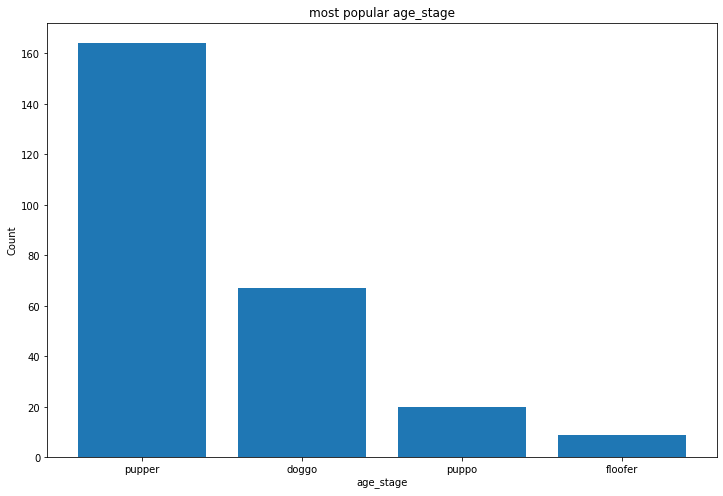

In [725]:
plt.subplots(figsize=(12, 8))
plt.bar([1, 2, 3, 4], stage_count, tick_label=['pupper', 'doggo','puppo' ,'floofer'])
plt.title('most popular age_stage')
plt.xlabel('age_stage')
plt.ylabel('Count')
plt.savefig('age_stage.png');

**the most commone age stge is : <font color=green> pupper <font>**

In [649]:
tweet_df.groupby(['age_stage'])['dog_rate'].mean()

age_stage
doggo            11.865672
floofer          11.888889
not specified    10.878932
pupper           11.140244
puppo            12.000000
Name: dog_rate, dtype: float64

**the highest average rate is for : <font color=green> puppo <font>**

### 2-  discover the most popular dog type 

In [665]:
tweet_df.dog_type.value_counts()[0:6]

golden_retriever      137
Labrador_retriever     94
Pembroke               88
Chihuahua              78
pug                    54
chow                   41
Name: dog_type, dtype: int64

**the most popular dog type is : <font color=green> golden retriever <font>**

### 3- discover the dog types that seem to get the highest Average rating

In [683]:
dog_types=tweet_df.groupby(['dog_type']).filter(lambda x: len(x) >= 25)


In [714]:
top_dog_rate=dog_types.groupby(['dog_type'])['dog_rate'].mean().sort_values(ascending=False)[:10]

In [715]:
top_dog_rate

dog_type
Samoyed               11.700000
golden_retriever      11.627007
chow                  11.609756
Pembroke              11.443182
cocker_spaniel        11.296296
French_bulldog        11.269231
Labrador_retriever    11.092553
Pomeranian            11.092105
toy_poodle            11.054054
malamute              10.896552
Name: dog_rate, dtype: float64

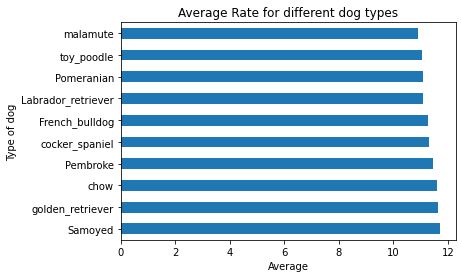

In [717]:
top_dog_rate.plot(kind = 'barh')
plt.title('Average Rate for different dog types')
plt.xlabel('Average')
plt.ylabel('Type of dog')

fig.savefig('avg_type.png');

### 4- discover the dog types that seem to get the highest Average tweets favorite

In [719]:
dog_type=tweet_df.groupby(['dog_type']).filter(lambda x: len(x) >= 25)
dog_favorite=dog_type.groupby(['dog_type'])['favorite_count'].mean().sort_values(ascending=False)[:10]
dog_favorite

dog_type
French_bulldog        17082.400000
Samoyed               12007.435897
golden_retriever      11256.248175
Labrador_retriever    10455.695652
cocker_spaniel        10413.740741
Pembroke              10314.000000
chow                   9030.219512
Chihuahua              8014.794872
malamute               7834.344828
Pomeranian             7294.815789
Name: favorite_count, dtype: float64

In [721]:
fav_df = pd.DataFrame()
fav_df['dog_Average_favorite'] = dog_favorite
fav_df

,dog_Average_favorite
dog_type,
French_bulldog,17082.400000
Samoyed,12007.435897
golden_retriever,11256.248175
Labrador_retriever,10455.695652
cocker_spaniel,10413.740741
Pembroke,10314.000000
chow,9030.219512
Chihuahua,8014.794872
malamute,7834.344828


**<font color='green'> French bulldog <font>** is the most favorite dog type